CUDA available: True


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Phase 1 Denoising ###


  0%|          | 0/50 [00:00<?, ?it/s]

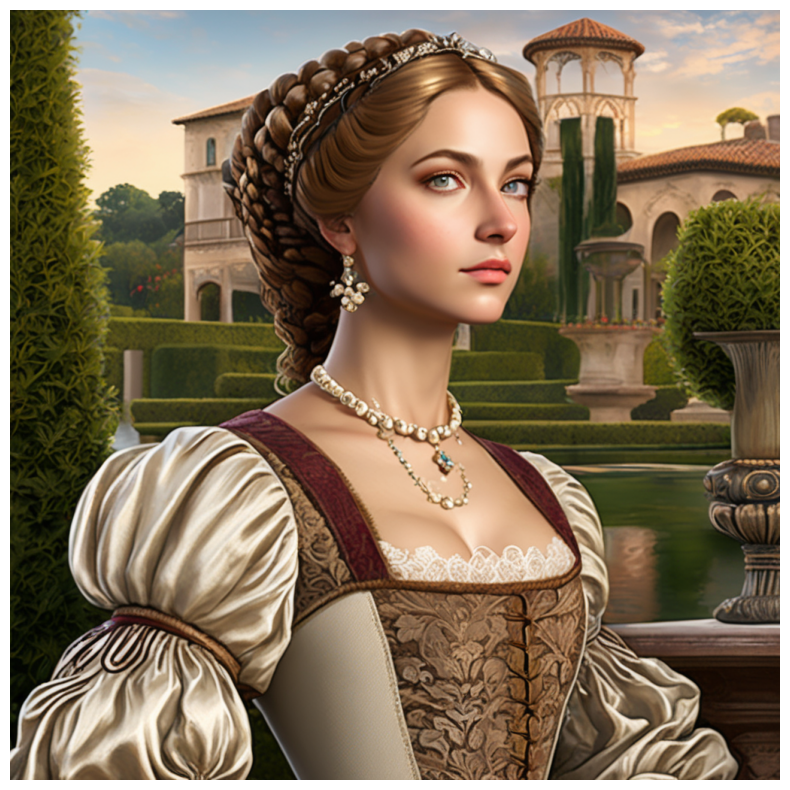

### total resample times: 2 ###
### resample times: 1 ###


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

### resample times: 2 ###


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

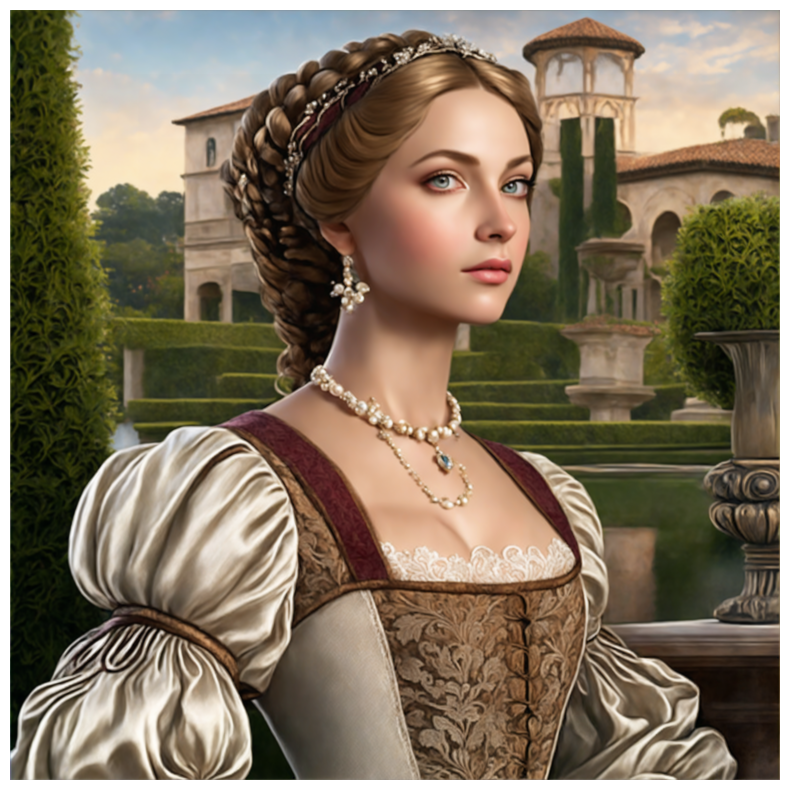

END


In [1]:
import os
import torch

from pipeline_apldm_sdxl import APLDMSDXLPipeline


gpu_ids = 5
image_sizes = [(3072, 3072)]
prompt = 'A Renaissance noblewoman, portrayed in an elegant gown with intricate embroidery. Her expression is thoughtful, and her eyes are deep and insightful. The background is a lush Italian garden, reflecting the artistic style of the High Renaissance.'
init_rates = [0.8, 0.8]
attn_guidance_scale = 0.005
attn_guidance_density = [0]*31 + [1]*16 + [0]*3  # [1]*47 + [0]*3
attn_guidance_decay = None  # ('cosine', 0, 3)
multi_encoder = True
multi_decoder = True
models_to_cpu = True
avoid_memory_fragment = True
encoder_limit_area = 3000**2
decoder_limit_area = 2048**2
random_seed = 523
num_images_per_prompt = 1
num_inference_steps = 50
num_resample_timesteps = 50
show_image = True
save_image = True


if __name__ == '__main__':
    if avoid_memory_fragment:
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
    
    print(f'CUDA available: {torch.cuda.is_available()}')
    device = f'cuda:{gpu_ids}'
    
    negative_prompt = "blurry, ugly, duplicate, poorly drawn, deformed, mosaic"
    
    model_ckpt = "stabilityai/stable-diffusion-xl-base-1.0"
    pipe = APLDMSDXLPipeline.from_pretrained(
        model_ckpt,
        torch_dtype=torch.float16,
        variant="fp16",
        cache_dir='../pretrained_models',
        local_files_only=True
    )
    pipe = pipe.to(device)
    attn_guidance_density = tuple(attn_guidance_density)

    with torch.no_grad():
        for idx1, image_size in enumerate(image_sizes):
            save_dir = f'./cases/init_rates_{init_rates}/guidance_scale_{attn_guidance_scale}'
            torch.manual_seed(random_seed)
            generator = torch.Generator(device)
            save_dir = os.path.join(save_dir, f'{str(image_size)}')
            os.makedirs(save_dir, exist_ok=True)
            for idx2 in range(num_images_per_prompt):
                torch.cuda.empty_cache()
                seed = torch.randint(0, 10000, (1,)).item()
                generator = generator.manual_seed(seed)
                images = pipe(
                    prompt, negative_prompt=negative_prompt, generator=generator,
                    height=image_size[0], width=image_size[1],
                    num_inference_steps=num_inference_steps, guidance_scale = 7.5,
                    multi_decoder=multi_decoder, show_image=show_image,
                    multi_encoder = multi_encoder, models_to_cpu = models_to_cpu,
                    encoder_limit_area = encoder_limit_area, decoder_limit_area = decoder_limit_area,
                    num_resample_timesteps = num_resample_timesteps,
                    init_rates = init_rates,
                    attn_type = 'vanilla',
                    attn_guidance_scale = attn_guidance_scale,
                    attn_guidance_density = attn_guidance_density,
                    attn_guidance_decay = attn_guidance_decay,
                    power_calibrate = 0,
                    attn_guidance_filter = None,
                )
                if save_image:  
                    file_name = f'{idx2}.png'
                    images[-1].save(os.path.join(save_dir, file_name))
                    del images
    print('END')